In [1]:
# Will only work on the JHub or Unix-like systems;
# saves data to the COVID-19_cases_casesByDay file

!wget https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Influenza/geography_types/Nation/geographies/England/metrics/influenza_healthcare_hospitalAdmissionRateByWeek

--2024-10-25 13:14:51--  https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Influenza/geography_types/Nation/geographies/England/metrics/influenza_healthcare_hospitalAdmissionRateByWeek
Resolving api.ukhsa-dashboard.data.gov.uk (api.ukhsa-dashboard.data.gov.uk)... 108.138.217.42, 108.138.217.58, 108.138.217.88, ...
Connecting to api.ukhsa-dashboard.data.gov.uk (api.ukhsa-dashboard.data.gov.uk)|108.138.217.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2234 (2.2K) [application/json]
Saving to: ‘influenza_healthcare_hospitalAdmissionRateByWeek.3’

influenza_healthcar 100%[===================>]   2.18K  --.-KB/s    in 0s      

2024-10-25 13:14:51 (1.07 GB/s) - ‘influenza_healthcare_hospitalAdmissionRateByWeek.3’ saved [2234/2234]



In [1]:
#!cat influenza_healthcare_hospitalAdmissionRateByWeek

In [3]:
import requests

# requests.get("https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Influenza/geography_types/Nation/geographies/England/metrics/influenza_healthcare_hospitalAdmissionRateByWeek",
            # params={'year': 2024, 'page_size': 3, 'page': 1}).json()

In [15]:
import requests
import time

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    # time of last api access
    _last_access=0.0 

    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters, increase when you start looping 
        over all pages. """
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

In [16]:
structure={"theme": "infectious_disease", 
           "sub_theme": "respiratory",
           "topic": "Influenza",
           "geography_type": "Nation", 
           "geography": "England"}

In [17]:
structure["metric"]="influenza_healthcare_hospitalAdmissionRateByWeek" 

In [18]:
#** unpacks the structure dictionary over the __init__ arguments
api=APIwrapper(**structure)
data=api.get_page() # default size is 5
# print(api.count)
# print(data)

In [19]:
# Let's filter for the year 2024.
# None values will be ignored by the APIwrapper

filters={"stratum" : None, # Smallest subgroup a metric can be broken down into e.g. ethnicity, testing pillar
         "age": None, # Smallest subgroup a metric can be broken down into e.g. 15_44 for the age group of 15-44 years
         "sex": None, #  Patient gender e.g. 'm' for Male, 'f' for Female or 'all' for all genders
         "year": 2024, #  Epi year of the metrics value (important for annual metrics) e.g. 2020
         "month": None, # Epi month of the metric value (important for monthly metrics) e.g. 12
         "epiweek" :None, # Epi week of the metric value (important for weekly metrics) e.g. 30
         "date" : None, # The date which this metric value was recorded in the format YYYY-MM-DD e.g. 2020-07-20
         "in_reporting_delay_period": None # Boolean indicating whether the data point is considered to be subject to retrospective updates
        }

In [21]:
data_2024=api.get_page(filters, page_size=3)
# print(api.count)
# print(data_2024)

In [22]:
#
structure["metric"]="influenza_healthcare_hospitalAdmissionRateByWeek" 

api=APIwrapper(**structure)
cases_hosp=[]
page=1
while True:
    data=api.get_page(page_size=365)
    print(f"Pages retrieved: {page}")
    if data==[]:
        break
    cases_hosp.extend(data)
    page+=1
# print(f"Data points expected: {api.count}")
# print(f"Data points retrieved: {len(cases_hosp)}")

Pages retrieved: 1
Pages retrieved: 2
Pages retrieved: 3
Pages retrieved: 4
Pages retrieved: 5
Pages retrieved: 6
Pages retrieved: 7
Pages retrieved: 8


In [23]:
structure["metric"]="influenza_healthcare_ICUHDUadmissionRateByWeek" 

api=APIwrapper(**structure)
cases_ICU=[]
page=1
while True:
    data=api.get_page(page_size=365)
    print(f"Pages retrieved: {page}")
    if data==[]:
        break
    cases_ICU.extend(data)
    page+=1
# print(f"Data points expected: {api.count}")
# print(f"Data points retrieved: {len(cases_ICU)}")

Pages retrieved: 1
Pages retrieved: 2
Pages retrieved: 3
Pages retrieved: 4
Pages retrieved: 5
Pages retrieved: 6
Pages retrieved: 7
Pages retrieved: 8


In [24]:
structure["metric"]="influenza_testing_positivityByWeek" 

api=APIwrapper(**structure)
cases_poswk=[]
page=1
while True:
    data=api.get_page(page_size=365)
    print(f"Pages retrieved: {page}")
    if data==[]:
        break
    cases_poswk.extend(data)
    page+=1
# print(f"Data points expected: {api.count}")
# print(f"Data points retrieved: {len(cases_poswk)}")

Pages retrieved: 1
Pages retrieved: 2
Pages retrieved: 3
Pages retrieved: 4
Pages retrieved: 5
Pages retrieved: 6
Pages retrieved: 7
Pages retrieved: 8
Pages retrieved: 9
Pages retrieved: 10


In [26]:
import json

In [27]:
with open("cases_hosp.json", "wt") as OUTF:
    json.dump(cases_hosp, OUTF)

In [28]:
with open("cases_ICU.json", "wt") as OUTF:
    json.dump(cases_ICU, OUTF)

In [29]:
with open("cases_poswk.json", "wt") as OUTF:
    json.dump(cases_poswk, OUTF)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [31]:
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [32]:
with open("cases_hosp.json", "rt") as INFILE:
    cases_hosp=json.load(INFILE)
with open("cases_ICU.json", "rt") as INFILE:
    cases_ICU=json.load(INFILE)
with open("cases_poswk.json", "rt") as INFILE:
    cases_poswk=json.load(INFILE)

In [33]:
#cases_hosp[:5]

In [34]:
data1={}
for dataset in [cases_ICU, cases_hosp, cases_poswk]:
    for entry in dataset:
        age=entry['age']
        metric=entry['metric']
        value=entry['metric_value']
        if age not in data1:
            data1[age]={}
        data1[age][metric]=value


In [35]:
def sortkey(interval):
    start=interval
    if '-' in interval:
        interval=interval.split('-')[-1]
    if '+' in interval:
        interval=interval.replace('+', '')
        interval=int(interval)+1
    else:
        interval=int(interval)
    #print(f"{start}->{interval}")
    return interval

In [36]:
ages=list(data1.keys())
ages.remove('all')
ages.sort(key=sortkey)


In [37]:
def normalise(interval):
    if '-' in interval:
        interval=interval.split('-')
        start=int(interval[0])
        end=int(interval[1])
        interval=f'{start:02d}-{end:02d}'
    return interval

newages=[]
for x in ages:
    y=normalise(x) 
    if y not in newages:
        newages.append(y)


In [38]:
#index=pd.date_range(startdate, enddate, freq='D')
agedf=pd.DataFrame(index=newages, columns=['cases_hosp', 'cases_ICU', 'cases_poswk'])
agedf

,cases_hosp,cases_ICU,cases_poswk
00-04,NaN,NaN,NaN
05-14,NaN,NaN,NaN
15-44,NaN,NaN,NaN
45-54,NaN,NaN,NaN
55-64,NaN,NaN,NaN
45-64,NaN,NaN,NaN
65,NaN,NaN,NaN
65+,NaN,NaN,NaN
65-74,NaN,NaN,NaN
65-79,NaN,NaN,NaN


In [39]:
# translate the columns to our metrics
metrics ={'cases_hosp': 'influenza_healthcare_hospitalAdmissionRateByWeek',
          'cases_ICU': 'influenza_healthcare_ICUHDUadmissionRateByWeek',
          'cases_poswk': 'influenza_testing_positivityByWeek'}

for age, entry in data1.items(): # each entry is a dictionary with cases, admissions and deaths
    #pd_age=parse_age(age) # convert to Pandas format
    for column in ['cases_hosp', 'cases_ICU', 'cases_poswk']: 
        metric_name=metrics[column]
        # do not assume all values are there for every date - if a value is not available, insert a 0.0
        value= entry.get(metric_name, 0.0)
        # this is the way you access a specific location in the dataframe - use .loc
        # and put index,column in a single set of [ ]
        agedf.loc[normalise(age), column]=value
            
# fill in any remaining "holes" due to missing dates
agedf.fillna(0.0, inplace=True)
            
# agedf

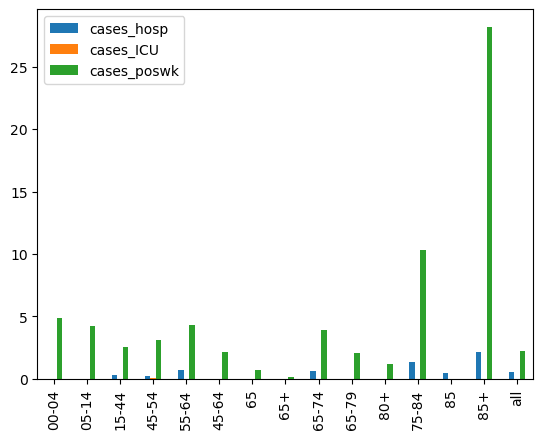

In [40]:
ax = agedf.plot(kind='bar')

In [41]:
data={}
for dataset in [cases_ICU, cases_hosp, cases_poswk]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][metric]=value


In [42]:
dates=list(data.keys())
dates.sort()


In [43]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [44]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)

2015-06-29 00:00:00  to  2024-10-14 00:00:00


In [45]:
index=pd.date_range(startdate, enddate, freq='D')
timeseriesdf=pd.DataFrame(index=index, columns=['cases_hosp', 'cases_ICU', 'cases_poswk'])
timeseriesdf

,cases_hosp,cases_ICU,cases_poswk
2015-06-29,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN
2015-07-01,NaN,NaN,NaN
2015-07-02,NaN,NaN,NaN
2015-07-03,NaN,NaN,NaN
...,...,...,...
2024-10-10,NaN,NaN,NaN
2024-10-11,NaN,NaN,NaN
2024-10-12,NaN,NaN,NaN
2024-10-13,NaN,NaN,NaN


In [46]:
# translate the columns to our metrics
metrics ={'cases_hosp': 'influenza_healthcare_hospitalAdmissionRateByWeek',
          'cases_ICU': 'influenza_healthcare_ICUHDUadmissionRateByWeek',
          'cases_poswk': 'influenza_testing_positivityByWeek'}

for date, entry in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for column in ['cases_hosp', 'cases_ICU', 'cases_poswk']: 
        metric_name=metrics[column]
        # do not assume all values are there for every date - if a value is not available, insert a 0.0
        value= entry.get(metric_name, 0.0)
        # this is the way you access a specific location in the dataframe - use .loc
        # and put index,column in a single set of [ ]
        timeseriesdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)
            
timeseriesdf

/tmp/ipykernel_701/1132758090.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  timeseriesdf.fillna(0.0, inplace=True)


,cases_hosp,cases_ICU,cases_poswk
2015-06-29,0.00,0.0,0.00
2015-06-30,0.00,0.0,0.00
2015-07-01,0.00,0.0,0.00
2015-07-02,0.00,0.0,0.00
2015-07-03,0.00,0.0,0.00
...,...,...,...
2024-10-10,0.00,0.0,0.00
2024-10-11,0.00,0.0,0.00
2024-10-12,0.00,0.0,0.00
2024-10-13,0.00,0.0,0.00


In [47]:
newdf = timeseriesdf.reset_index()
#newd['index'].sum()

newdf

,index,cases_hosp,cases_ICU,cases_poswk
0,2015-06-29,0.00,0.0,0.00
1,2015-06-30,0.00,0.0,0.00
2,2015-07-01,0.00,0.0,0.00
3,2015-07-02,0.00,0.0,0.00
4,2015-07-03,0.00,0.0,0.00
...,...,...,...,...
3391,2024-10-10,0.00,0.0,0.00
3392,2024-10-11,0.00,0.0,0.00
3393,2024-10-12,0.00,0.0,0.00
3394,2024-10-13,0.00,0.0,0.00


In [48]:
newdf_hosp = newdf['cases_hosp'].sum()
newdf_ICU = newdf['cases_ICU'].sum()
newdf_poswk = newdf['cases_poswk'].sum()

print(newdf_hosp, newdf_ICU, newdf_poswk)



483.61 28.42 1610.46


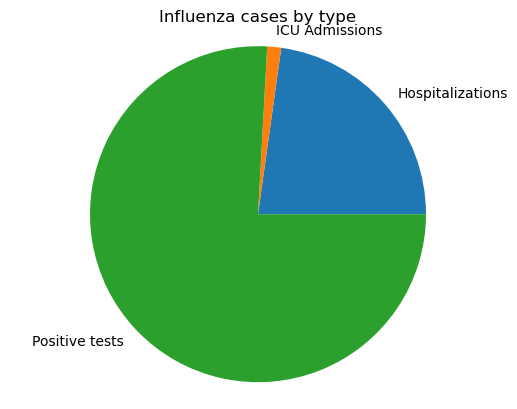

In [49]:


import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

sizes = [newdf_hosp, newdf_ICU, newdf_poswk]
labels = 'Hospitalizations', 'ICU Admissions', 'Positive tests'


plt.pie(sizes,
       labels = labels)


plt.title('Influenza cases by type')
plt.axis('equal')


plt.show()



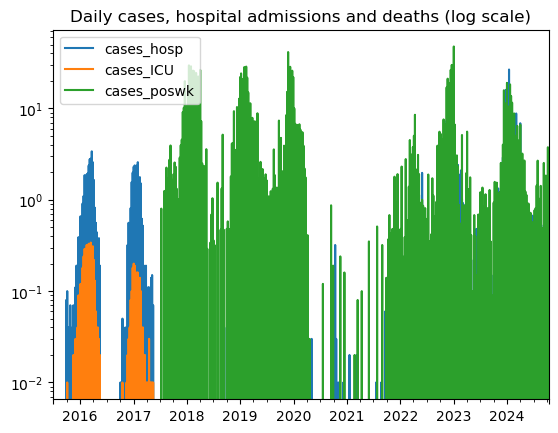

In [50]:
ax=timeseriesdf.plot(logy=True) # ...lemon squeezy
ax.set_title('Daily cases, hospital admissions and deaths (log scale)');

In [52]:
# ax = timeseriesdf.plot(kind='hist', bins=30)

In [53]:
# ax = timeseriesdf.hist(bins=30)

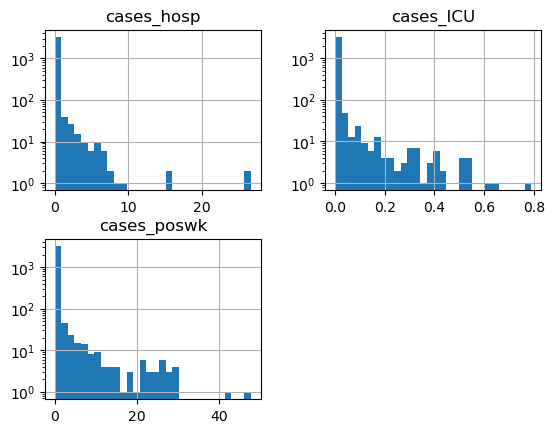

In [54]:
ax = timeseriesdf.hist(bins=30,log=True)

In [55]:
# ax = timeseriesdf.plot(kind='bar')

In [56]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100


In [58]:
# our API access function. This will be called by the button when it is clicked
def access_api(button):
    # Ignore the button parameter
    #
    # put code for polling the API here
    #
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again.
    apibutton.icon="check"
    apibutton.disabled=True

# see the doc for the parameters    
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    icon='download' # (FontAwesome names without the `fa-` prefix)
)

# register the callback function with the button
apibutton.on_click(access_api)

# this is an iPython function that generalises print for Jupyter Notebooks; we use it to 
# display the widgets
display(apibutton)

Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click to download current Pu…

In [59]:
timeseriesdf.to_pickle("timeseriesdf.pkl")

In [60]:
# in the dashboard, this should be computed from the json files
timeseriesdf=pd.read_pickle("timeseriesdf.pkl")

Select(description='Year', index=9, options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024), rows…

Output()

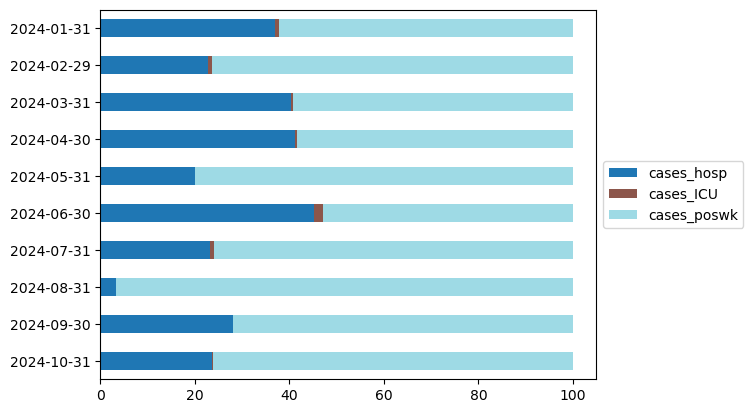

In [61]:
year=wdg.Select(
    # options available: unique years in the dataframe
    options=timeseriesdf.index.year.unique(), # options available
    value=timeseriesdf.index.year[-1], # initial value: most recent year
    rows=1, # rows of the selection box
    description='Year',
    disabled=False
)

def lineage_graph(graphyear):
    # our callback function.
    yeardf=timeseriesdf[timeseriesdf.index.year==graphyear]
    # average the rows by month
    monthly= yeardf.groupby(pd.Grouper(freq='1ME')).mean() 
    totals=monthly.sum(axis=1) # over the rows
    # make sure it's all normalised to 100
    monthly=monthly.div(totals, axis=0)*100
    # older dates on top of the graph
    monthly = monthly[::-1]
    ax=monthly.plot(kind='barh', stacked=True,cmap='tab20')
    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    ax.set_yticklabels(monthly.index.strftime('%Y-%m-%d'))

output=wdg.interactive_output(lineage_graph, {'graphyear': year})

display(year, output)

In [62]:
series=wdg.SelectMultiple(
    options=['cases_hosp', 'cases_ICU', 'cases_poswk'],
    value=['cases_hosp', 'cases_ICU', 'cases_poswk'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); 
# capture output in widget graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()